Dispositivo selecionado: cuda (NVIDIA GeForce RTX 3060 Ti)


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2025-01-17  196.000000  197.229996  193.750000  196.529999  27735100
2025-01-21  198.050003  202.289993  197.869995  199.070007  29971300
2025-01-22  198.369995  200.479996  197.529999  199.059998  26200600
2025-01-23  197.979996  200.300003  195.199997  198.139999  26951400
2025-01-24  200.210007  200.899994  198.000000  198.100006  23877500
4796 dias
Train set: 3831 samples, Test set: 955 samples
Epoch 1/50, Train Loss: 0.032082, Test Loss: 0.006913
Epoch 2/50, Train Loss: 0.000363, Test Loss: 0.030599
Epoch 3/50, Train Loss: 0.000191, Test Loss: 0.041999
Epoch 4/50, Train Loss: 0.000165, Test Loss: 0.048382
Epoch 5/50, Train Loss: 0.000159, Test Loss: 0.045034
Epoch 6/50, Train Loss: 0.000160, Test Loss: 0.037323
Epoch 7/50, Train Loss: 0.000151, Test Loss: 0.033873
Epoch 8/50, T

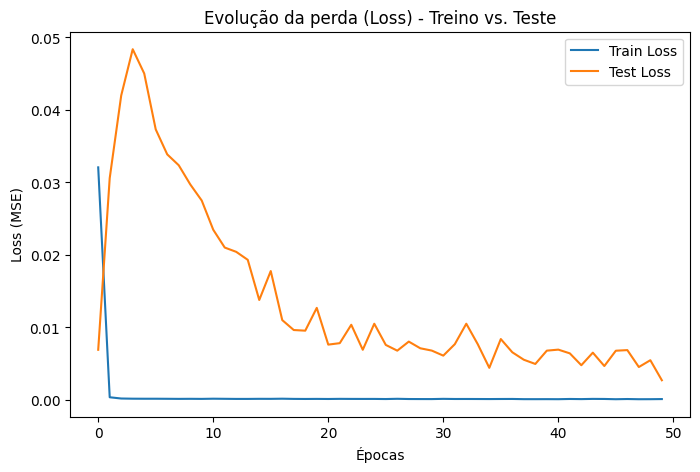


Desempenho no Teste:
MAE : 3.7457
RMSE: 5.0680


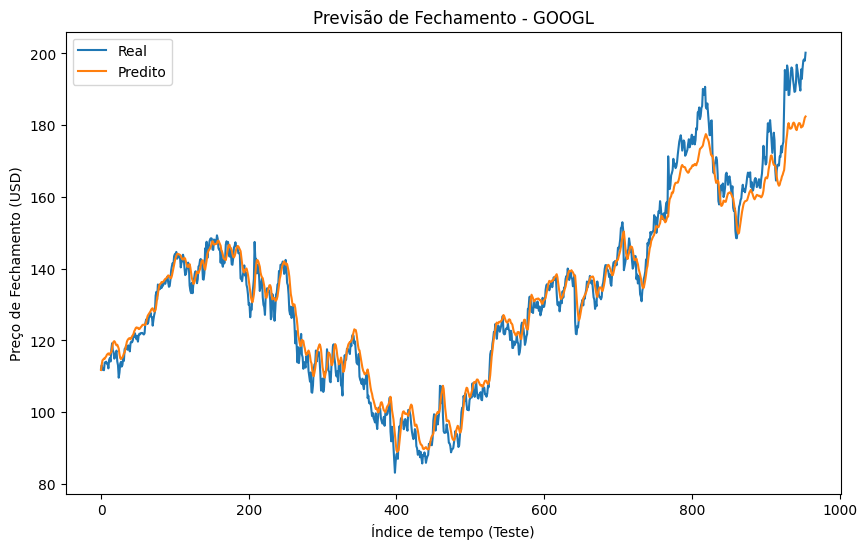

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------------------
# Parâmetros do modelo e do dataset
# ---------------------------
SEQUENCE_LENGTH = 5
TEST_RATIO = 0.2
INPUT_SIZE = 1
HIDDEN_SIZE = 50
NUM_LAYERS = 2
OUTPUT_SIZE = 1
EPOCHS = 50  # Aumentamos para observar melhor a evolução
LR = 0.001    # Taxa de aprendizado

# Parâmetros de early stopping
PATIENCE = 10

# Informações sobre o papel e período histórico
TICKER = "GOOGL"
HISTORICAL_START_DATE = "2006-01-01"
HISTORICAL_END_DATE = "2025-01-25"

# ---------------------------
# Verificar se GPU está disponível
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
else:
    gpu_name = "CPU"
print(f"Dispositivo selecionado: {DEVICE} ({gpu_name})")

# ---------------------------
# Função para criar sequências
# ---------------------------
def create_sequences(data, seq_length):
    """
    Gera sequências (X) e rótulos (y) para uso em modelos de deep learning.
    data: array numpy com dados normalizados
    seq_length: comprimento da janela temporal (número de dias passados)

    Retorna:
    sequences: dados de entrada, shape (n_amostras, seq_length, 1)
    labels: dados de saída (dia seguinte), shape (n_amostras, 1)
    """
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)


# ---------------------------
# Baixar dados históricos
# ---------------------------
df = yf.download(TICKER, start=HISTORICAL_START_DATE, end=HISTORICAL_END_DATE)
print(df.tail())
print(len(df), "dias")

# Selecionar apenas a coluna de fechamento
closing_prices = df[["Close"]].values

# ---------------------------
# Dividir para treino e teste (por índice, mantendo ordem temporal)
# ---------------------------
split_index = int(len(closing_prices) * (1 - TEST_RATIO))
train_prices = closing_prices[:split_index]
test_prices  = closing_prices[split_index:]

# ---------------------------
# Normalizar SOMENTE com dados de treino
# ---------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_prices)

# Transformar os dados de treino e teste
train_prices_scaled = scaler.transform(train_prices)
test_prices_scaled  = scaler.transform(test_prices)

# ---------------------------
# Criar sequência de dados para LSTM
# ---------------------------
train_sequences, train_labels = create_sequences(train_prices_scaled, SEQUENCE_LENGTH)
test_sequences, test_labels   = create_sequences(test_prices_scaled, SEQUENCE_LENGTH)

# ---------------------------
# Converter para tensores do PyTorch
# ---------------------------
train_X = torch.tensor(train_sequences, dtype=torch.float32).to(DEVICE)
train_y = torch.tensor(train_labels, dtype=torch.float32).to(DEVICE)
test_X  = torch.tensor(test_sequences,  dtype=torch.float32).to(DEVICE)
test_y  = torch.tensor(test_labels,     dtype=torch.float32).to(DEVICE)


# ---------------------------
# Dataset e DataLoaders
# ---------------------------
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(train_X, train_y)
test_dataset  = StockDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

print(f"Train set: {len(train_dataset)} samples, "
      f"Test set: {len(test_dataset)} samples")


# ---------------------------
# Definição do modelo LSTM
# ---------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(DEVICE)

        # out => [batch_size, seq_length, hidden_size]
        out, _ = self.lstm(x, (h0, c0))

        # Pega apenas a última saída da sequência
        out = out[:, -1, :]

        # Passa pela camada totalmente conectada
        out = self.fc(out)
        return out


# Instanciar modelo, loss, optimizer
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ---------------------------
# Função de avaliação
# ---------------------------
def evaluate_model(model_eval, data_loader, loss_fn):
    model_eval.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model_eval(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# ---------------------------
# Loop de treinamento (com Early Stopping)
# ---------------------------
best_loss = float('inf')
patience_counter = 0

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    avg_test_loss = evaluate_model(model, test_loader, criterion)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {avg_train_loss:.6f}, "
          f"Test Loss: {avg_test_loss:.6f}")

    # Early Stopping: se não houve melhora, aumentamos o contador
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        # patience_counter = 0
        # Opcional: salvar o modelo
        # torch.save(model.state_dict(), "best_model.pth")
    # else:
    #     patience_counter += 1
    #     if patience_counter >= PATIENCE:
    #         print("Early stopping!")
    #         break

print(f"Melhor Loss: {best_loss:.6f}")

# Carregar o melhor modelo (opcional)
# model.load_state_dict(torch.load("best_model.pth"))

# ---------------------------
# Plot da curva de perdas
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Evolução da perda (Loss) - Treino vs. Teste")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# ---------------------------
# Função de predição
# ---------------------------
def predict(model_pred, data_loader):
    model_pred.eval()
    predictions_list = []
    actual_values_list = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model_pred(inputs)
            predictions_list.extend(outputs.cpu().numpy())
            actual_values_list.extend(targets.cpu().numpy())
    return np.array(predictions_list), np.array(actual_values_list)

# Obter predições no teste
predictions, actual_values = predict(model, test_loader)

# Reverter a normalização
# Note que 'predictions' está shape (N, 1), já 'actual_values' também (N, 1).
predictions_inv = scaler.inverse_transform(predictions)
actual_inv = scaler.inverse_transform(actual_values)

# Calcular métricas
mae_value = mean_absolute_error(actual_inv, predictions_inv)
rmse_value = np.sqrt(mean_squared_error(actual_inv, predictions_inv))

print(f"\nDesempenho no Teste:")
print(f"MAE : {mae_value:.4f}")
print(f"RMSE: {rmse_value:.4f}")

# ---------------------------
# Plotar valores reais vs. predições
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(actual_inv, label='Real')
plt.plot(predictions_inv, label='Predito')
plt.title(f"Previsão de Fechamento - {TICKER}")
plt.xlabel("Índice de tempo (Teste)")
plt.ylabel("Preço de Fechamento (USD)")
plt.legend()
plt.show()

In [2]:
def predict_n_days_ahead(
    n_ahead,
    df,
    model,
    scaler,
    sequence_length
):
    """
    Faz predições para n_ahead dias além do último dia disponível no df,
    usando a abordagem recursiva (walk-forward).
    Retorna uma lista de valores previstos (em escala original).
    """
    model.eval()

    # Extrair os últimos 'sequence_length' fechamentos reais do DF
    last_sequence = df['Close'].values[-sequence_length:]
    # Escalonar
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))

    predictions = []

    # Convertemos a sequência em lista (para inserir valores previstos gradualmente)
    seq_list = list(last_sequence_scaled.flatten())

    for _ in range(n_ahead):
        # Converte a lista atual em tensor [1, seq_len, 1]
        seq_tensor = torch.tensor(seq_list[-sequence_length:], dtype=torch.float32)
        seq_tensor = seq_tensor.unsqueeze(0).unsqueeze(-1).to(DEVICE)

        with torch.no_grad():
            pred_scaled = model(seq_tensor)
        # pred_scaled => shape (1, 1)
        # Inverter o scaling
        pred = scaler.inverse_transform(pred_scaled.cpu().numpy().reshape(-1, 1))
        pred_value = float(pred[0][0])

        predictions.append(pred_value)

        # Adiciona esse valor previsto ao final da sequência
        # para que ele seja usado na próxima predição
        new_val_scaled = pred_scaled.cpu().numpy().item()
        seq_list.append(new_val_scaled)

    return predictions

# Supondo que df contenha dados até 2023-10-15
future_preds = predict_n_days_ahead(
    n_ahead=5,          # Quantos dias além do último dia do dfop
    df=df,
    model=model,
    scaler=scaler,
    sequence_length=SEQUENCE_LENGTH
)

print("Previsões para os próximos 5 dias após o último dia do df:")
print(future_preds)

Previsões para os próximos 5 dias após o último dia do df:
[183.19668579101562, 180.94422912597656, 178.42593383789062, 175.7201385498047, 172.9312286376953]
